In [7]:
import sys, os
sys.path.append('..')
sys.path.append('../..')

In [8]:
import autograd

In [9]:
import pickle

In [10]:
import pystan

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import autograd.numpy as np
#import pystan
from viabel import all_bounds
from viabel.vb import (mean_field_gaussian_variational_family,
                       mean_field_t_variational_family,
                       t_variational_family,
                       black_box_klvi,
                       black_box_klvi_pd,
                       black_box_klvi_pd2,
                       black_box_chivi,
                       make_stan_log_density,
                       adagrad_optimize
                      )
from experiments import (get_samples_and_log_weights, 
                         plot_history, 
                         plot_approx_and_exact_contours, 
                         check_approx_accuracy,
                         print_bounds)

from data_generator import (data_generator_linear)

sns.set_style('white')
sns.set_context('notebook', font_scale=2, rc={'lines.linewidth': 2})

In [13]:
from viabel.vb import  rmsprop_IA_optimize_with_rhat, adam_IA_optimize_with_rhat

# Linear regression model example

We will approximate the posterior for the simple 2D robust linear regression model
$$\beta_i \sim \mathcal{N}(0, 10)$$
$$y_n | x_n, \beta, \sigma \sim \mathcal{T}_{10}(\beta^\top x_n, 1).$$

We will use Stan to take care of compute log probabilities and gradients for us. 

In [14]:
regression_model_code = """data {
  int<lower=0> N;   // number of observations
  int<lower=0> D;   // number of observations
  matrix[N, D] x;   // predictor matrix
  vector[N] y;      // outcome vector
}
parameters {
  vector[D] beta;       // coefficients for predictors
}

model {
  beta ~ normal(0, 10);
  #y ~ student_t(10, x * beta, 1);  // likelihood
  y ~ normal( x * beta, 0.5);  // likelihood
}"""

In [15]:

try:
    sm = pickle.load(open('robust_reg_model_1.pkl', 'rb'))
except:
    sm = pystan.StanModel(model_code=regression_model_code, model_name='regression_model')
    with open('robust_reg_model_1.pkl', 'wb') as f:
        pickle.dump(sm, f)


We generate 25 observations from the model with $\beta = (-2, 1)$.

In [16]:
SEED=5040
np.random.seed(SEED)
beta_gen = np.array([-2, 1])
N = 100
k=10
x = np.random.randn(N, 2).dot(np.array([[1,.85],[.85, 1]]))
y_raw = x.dot(beta_gen) + np.random.standard_t(10, N)
y = y_raw - np.mean(y_raw)

In [17]:
N=150
k=10
SEED= 5080
alpha=1.
noise_sigma = 0.4
noise_var = noise_sigma**2
rho = 0.5
regression_data = data_generator_linear(N, k, alpha=alpha,
                                                     noise_variance=noise_var,
                                                     rho=rho, seed=SEED)
X = regression_data['X']
Y = regression_data['Y']
Y=Y[:,0]
W = regression_data['W']

First, we generate ground truth samples using Stan's dynamic HMC implementation

In [18]:
data = dict(N=N, x=X, y=Y, D=k)
fit = sm.sampling(data=data)

In [19]:
true_mean = np.mean(fit['beta'], axis=0)
true_cov = np.cov(fit['beta'].T)

In [20]:
print(true_mean)

[ 1.35963163 -0.28618052  1.05948278 -0.37365413 -0.98515658 -1.27676812
 -0.65306289 -0.28511911  2.06734197  0.59684829]


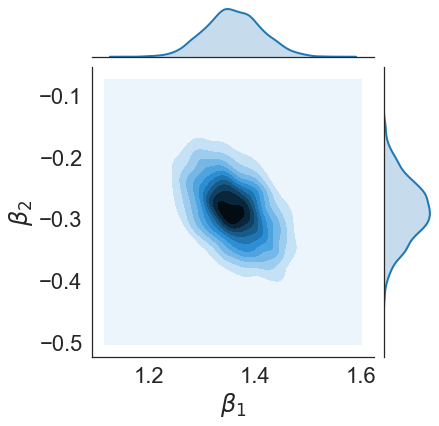

In [21]:
jp = sns.jointplot(x=fit['beta[1]'], y=fit['beta[2]'], kind='kde')
jp.set_axis_labels(r'$\beta_1$', r'$\beta_2$')
plt.show()

## Standard mean-field variational inference

Next, we compute a mean field variational approximation using standard variational inference (that is, minimizing the KL-divergence)

In [22]:
mf_g_var_family = mean_field_gaussian_variational_family(k)
stan_log_density = make_stan_log_density(fit)
klvi_objective_and_grad = black_box_klvi(mf_g_var_family, stan_log_density, 100)

init_mean    = np.zeros(k)
init_log_std = np.ones(k)
init_var_param = np.concatenate([init_mean, init_log_std])
n_iters = 5000



In [23]:
mf_g_var_family = mean_field_gaussian_variational_family(k)
stan_log_density = make_stan_log_density(fit)
klvi_objective_and_grad_pd = black_box_klvi_pd2(mf_g_var_family, stan_log_density, 100)

init_mean    = np.zeros(k)
#init_mean_random = np.random.normal([k], stddev=1.0)
init_log_std = np.ones(k)
#init_log_std_random = tf.random.normal([k], stddev=1.)
init_var_param = np.concatenate([init_mean, init_log_std])
n_iters = 4000

In [24]:
klvi_var_param, avg_klvi_var_param_list,_, klvi_history, _, op_log = \
    rmsprop_IA_optimize_with_rhat(n_iters, klvi_objective_and_grad, init_var_param, k, learning_rate=.01,n_optimisers=2)

100%|██████████| 4000/4000 [00:38<00:00, 104.50it/s]


(8, 2, 500, 20)
(2, 500, 20)
(2, 500, 20)
(2, 500, 20)
(2, 500, 20)
(2, 500, 20)
(2, 500, 20)
(2, 500, 20)
(2, 500, 20)


In [25]:
klvi_var_param_adam, avg_klvi_var_param_list_adam,_, klvi_history_adam, _, op_log_adam = \
    adam_IA_optimize_with_rhat(6000, klvi_objective_and_grad, init_var_param, k, learning_rate=.01,n_optimisers=2)

100%|██████████| 6000/6000 [01:01<00:00, 98.24it/s] 


(12, 2, 500, 20)
(2, 500, 20)
(2, 500, 20)
(2, 500, 20)
(2, 500, 20)
(2, 500, 20)
(2, 500, 20)
(2, 500, 20)
(2, 500, 20)
(2, 500, 20)
(2, 500, 20)
(2, 500, 20)
(2, 500, 20)


In [28]:
print(klvi_var_param)
print(klvi_var_param_adam)

[ 1.35806969 -0.29115626  1.05697198 -0.37573755 -0.98317268 -1.27589284
 -0.64967053 -0.28840383  2.07043963  0.60098171 -3.11682547 -3.29880137
 -3.19284393 -3.15547684 -3.1608993  -3.24793448 -3.19968143 -3.11026076
 -3.20271568 -3.22403334]
[ 1.36186074 -0.28835031  1.05760449 -0.37425456 -0.98299628 -1.27502252
 -0.65344422 -0.28849553  2.0690449   0.60174367 -1.59808156 -2.72490891
 -2.27087    -2.34877141 -1.90616801 -2.56828189 -2.31817674 -2.6280914
 -2.23737668 -1.91479606]


In [29]:
print(len(avg_klvi_var_param_list_adam))
print(avg_klvi_var_param_list_adam[1][-1])
print(avg_klvi_var_param_list_adam[0][-1])

2
[ 1.35858102 -0.28609934  1.06052529 -0.37402548 -0.98538522 -1.2761466
 -0.65335142 -0.28632809  2.06725664  0.59707635 -1.39575258 -2.54781603
 -2.07601719 -2.15958443 -1.70660446 -2.38357155 -2.12532159 -2.45677564
 -2.04294256 -1.71370875]
[ 1.35948462 -0.286379    1.06097359 -0.37425136 -0.98524326 -1.27566862
 -0.65293837 -0.28646433  2.06748994  0.59727378 -2.03532864 -2.09786258
 -2.11348987 -2.11614679 -1.99905055 -2.16659056 -2.11311745 -1.95666417
 -2.09588739 -2.13447694]


In [30]:
print(op_log['start_avg_mean_iters'])
print(op_log_adam['start_avg_mean_iters'])

1000
4500


In [31]:
print(op_log['r_hat_mean'])
print(op_log_adam['r_hat_mean'])

[[ 4.71537791  3.41674316  2.2263366   6.3664453   2.84150109  4.70266468
   3.89309485 13.15211676  2.17955024  2.31879659]
 [ 2.24305433  2.82713551  2.14122641  3.85824926  1.99907012  2.69123392
   2.08657146  3.22157323  1.78007143  1.44182632]
 [ 1.05124104  1.0427016   1.02507058  1.02467841  1.00528947  1.01287732
   1.06621077  1.01472451  1.00498155  1.02485372]
 [ 1.01379503  1.00271678  0.9998515   1.00672084  1.00703636  1.0048961
   1.00550067  1.02050238  0.99984592  1.00521751]
 [ 0.99949421  0.99921782  1.01397878  1.02019491  0.99863631  1.00637064
   1.01028496  1.00002812  0.99935349  1.01379644]
 [ 1.00419353  1.00361368  1.00180558  0.99901489  1.0000097   0.9990491
   0.99961102  0.99874472  0.99841203  1.00647536]
 [ 1.00468583  1.00586706  0.99901819  1.00721422  0.99913287  0.99835953
   0.9998516   0.99841286  1.0064272   1.00389305]
 [ 1.00563101  1.0072116   1.0078462   1.00706854  1.002545    0.99810114
   1.00542829  1.00175602  0.99980585  1.01359589]]
[

In [ ]:
### Optimisation using Adagrad and Iterate Averaging

In [ ]:
#plot_approx_and_exact_contours(stan_log_density, mf_g_var_family, init_var_param, xlim=[-6,0], ylim=[-1,6])
klvi_var_param, _, klvi_history, _ = \
    adagrad_optimize(n_iters, klvi_objective_and_grad, init_var_param, learning_rate=.01)

In [ ]:
klvi_var_param_pd, _, averaged_klvi_var_param_pd, klvi_history_pd, _ = \
    rmsprop_IA_optimize(n_iters, klvi_objective_and_grad_pd, init_var_param, learning_rate=.01)

In [ ]:
plot_history(klvi_history)
plot_history(klvi_history_pd)
plot_history(klvi_history_pd - klvi_history)

### Optimisation using RMSProp and Iterate Averaging.

In [ ]:
#plot_approx_and_exact_contours(stan_log_density, mf_g_var_family, init_var_param, xlim=[-6,0], ylim=[-1,6])
klvi_var_param_rms, _, averaged_klvi_var_param_history_rms, klvi_history_rms, _ = \
    rmsprop_IA_optimize(n_iters, klvi_objective_and_grad, init_var_param, learning_rate=.01)

In [ ]:
averaged_klvi_var_param_rms= averaged_klvi_var_param_history_rms[-1]

In [ ]:
klvi_var_param_adam, _, averaged_klvi_var_param_history_adam, klvi_history_adam, _ = \
    adam_IA_optimize(15000, klvi_objective_and_grad, init_var_param, learning_rate=.013)

In [ ]:
averaged_klvi_var_param_adam = averaged_klvi_var_param_history_adam[-1]

We can plot the negative ELBO to visually verify convergence

In [ ]:
plot_history(klvi_history)
plot_history(klvi_history_rms)
plot_history(klvi_history_adam)

Due to the strong posterior correlation, the variational approximation dramatically underestimates uncertainty

In [ ]:
#plot_approx_and_exact_contours(stan_log_density, mf_g_var_family, klvi_var_param, xlim=[-6,0], ylim=[-1,6])

In [ ]:
#plot_approx_and_exact_contours(stan_log_density, mf_g_var_family, averaged_klvi_var_param, xlim=[-6,0], ylim=[-1,6])

In [ ]:
print(klvi_var_param)

In [ ]:
check_approx_accuracy(mf_g_var_family, klvi_var_param, true_mean, true_cov, verbose=True);

In [ ]:
check_approx_accuracy(mf_g_var_family, klvi_var_param_rms, true_mean, true_cov, verbose=True);

In [ ]:
check_approx_accuracy(mf_g_var_family, averaged_klvi_var_param_rms, true_mean, true_cov, verbose=True);

In [ ]:
check_approx_accuracy(mf_g_var_family, klvi_var_param_adam, true_mean, true_cov, verbose=True);

In [ ]:
check_approx_accuracy(mf_g_var_family, averaged_klvi_var_param_adam, true_mean, true_cov, verbose=True);

We can check approximation quality using `viabel`. All bounds suggest the approximation is not good. 

In [ ]:
model_param_samples, log_weights = \
    get_samples_and_log_weights(stan_log_density, mf_g_var_family, klvi_var_param, 1000000)
elbo = np.mean(log_weights)
var_dist_cov = mf_g_var_family.mean_and_cov(klvi_var_param)[1]
klvi_results = all_bounds(log_weights, model_param_samples, q_var=var_dist_cov)

In [ ]:
print_bounds(klvi_results)

In [ ]:
model_param_samples, log_weights = \
    get_samples_and_log_weights(stan_log_density, mf_g_var_family, averaged_klvi_var_param_rms, 1000000)
elbo_rmsia = np.mean(log_weights)
var_dist_cov_rmsia = mf_g_var_family.mean_and_cov(averaged_klvi_var_param_rms)[1]
klvi_results_rmsia = all_bounds(log_weights, model_param_samples, q_var=var_dist_cov_rmsia)

In [ ]:
print_bounds(klvi_results_rmsia)

In [ ]:
model_param_samples, log_weights = \
    get_samples_and_log_weights(stan_log_density, mf_g_var_family, averaged_klvi_var_param_adam, 1000000)
elbo_adamia = np.mean(log_weights)
var_dist_cov_adamia = mf_g_var_family.mean_and_cov(averaged_klvi_var_param_adam)[1]
klvi_results_adamia = all_bounds(log_weights, model_param_samples, q_var=var_dist_cov_adamia)

In [ ]:
print_bounds(klvi_results_adamia)

## Mean-field variational inference with CHIVI

We can repeat the same procedure, but this time using CHIVI and a Student t mean-field variational family. 

In [ ]:
mf_t_var_family = mean_field_t_variational_family(2, 40)
chivi_objective_and_grad = black_box_chivi(2, mf_t_var_family, stan_log_density, 500)

init_var_param = klvi_var_param.copy()
init_var_param[2:] += 3

chivi_var_param, _, chivi_history, _ = \
    adagrad_optimize(n_iters, chivi_objective_and_grad, init_var_param, learning_rate=.01) #, learning_rate_end=.01)

In [ ]:
plot_history(chivi_history)

The variance is no longer so dramically underestimated, though the variational approximation is still not very good. This is reflected is the large bounds.

In [ ]:
plot_approx_and_exact_contours(stan_log_density, mf_t_var_family, chivi_var_param, xlim=[-6,0], ylim=[-1,6])

In [ ]:
check_approx_accuracy(mf_t_var_family, chivi_var_param, true_mean, true_cov, verbose=True);

In [ ]:
model_param_samples, log_weights = \
    get_samples_and_log_weights(stan_log_density, mf_t_var_family, chivi_var_param, 1000000)
var_dist_cov = mf_t_var_family.mean_and_cov(chivi_var_param)[1]
chivi_results = all_bounds(log_weights, model_param_samples, q_var=var_dist_cov, log_norm_bound=elbo)

In [ ]:
print_bounds(chivi_results)

## Non-mean-field approximation

Finally, we obtain a very good approximation by using a Student t variational family with a full-rank scaling matrix. 

In [ ]:
t_var_family = t_variational_family(2, 40)
full_klvi_objective_and_grad = black_box_klvi(t_var_family, stan_log_density, 100)

init_var_param = np.zeros(t_var_family.var_param_dim)
plot_approx_and_exact_contours(stan_log_density, t_var_family, init_var_param, xlim=[-6,0], ylim=[-1,6])
full_klvi_var_param, _, full_klvi_history, _ = \
    adagrad_optimize(n_iters, full_klvi_objective_and_grad, init_var_param, 
                     learning_rate=.1, learning_rate_end=.001)


# full_var_dist = vb.StudentTDistribution(2, 40)
# full_klvi = vb.KLqp(full_var_dist, model)
# _, _, history, _ = vb.adagrad_optimize(
#     10000, full_klvi, n_samples=20, learning_rate=.1, learning_rate_end=.001)

In [ ]:
plot_history(full_klvi_history)

In [ ]:
plot_approx_and_exact_contours(stan_log_density, t_var_family, full_klvi_var_param, xlim=[-6,0], ylim=[-1,6])

In [ ]:
check_approx_accuracy(t_var_family, full_klvi_var_param, true_mean, true_cov, verbose=True);

Bounds computed using `viabel` -- and the 2-divergence bound in particular -- confirm that the approximation is accurate. 

In [ ]:
model_param_samples, log_weights = \
    get_samples_and_log_weights(stan_log_density, t_var_family, full_klvi_var_param, 1000000)
var_dist_cov = t_var_family.mean_and_cov(full_klvi_var_param)[1]
full_klvi_results = all_bounds(log_weights, model_param_samples, q_var=var_dist_cov)

In [ ]:
print_bounds(full_klvi_results)